In [1]:
seq = "TTCCACAAATACCTAAGTATTCTTTAATAATGGTGGTTTTTTTTTTTTTTTGCATCTATGAAGTTTTTTCAAATTCTTTTTAAGTGACAAAACTTGTACATGTGTATCGCTCAATATTTCTAGTCGACAGCACTGCTTTCGAGAATGTAAACCGTGCACTCCCAGGAAAATGCAGACACAGCACGCCTCTTTGGGACCGCGGTTTATACTTTCGAAGTGCTCGGAGCCCTTCCTCCAGACCGTTCTCCCACACCCCGCTCCAGGGTCTCTCCCGGAGTTACAAGCCTCGCTGTAGGCCCCGGGAACCCAACGCGGTGTCAGAGAAGTGGGGTCCCCTACGAGGGACCAGGAGCTCCGGGCGGGCAGCAGCTGCGGAAGAGCCGCGCGAGGCTTCCCAGAACCCGGCAGGGGCGGGAAGACGCAGGAGTGGGGAGGCGGAACCGGGACCCCGCAGAGCCCGGGTCCCTGCGCCCCACAAGCCTTGGCTTCCCTGCTAGGGCCGGGCAAGGCCGGGTGCAGGGCGCGGCTCCAGGGAGGAAGCTCCGGGGCGAGCCCAAGACGCCTCCCGGGCGGTCGGGGCCCAGCGGCGGCGTTCGCAGTGGAGCCGGGCACCGGGCAGCGGCCGCGGAACACCAGCTTGGCGCAGGCTTCTCGGTCAGGAACGGTCCCGGGCCTCCCGCCCGCCTCCCTCCAGCCCCTCCGGGTCCCCTACTTCGCCCCGCCAGGCCCCCACGACCCTACTTCCCGCGGCCCCGGACGCCTCCTCACCTGCGAGCCGCCCTCCCGGAAGCTCCCGCCGCCGCTTCCGCTCTGCCGGAGCCGCTGGGTCCTAGCCCCGCCGCCCCCAGTCCGCCCGCGCCTCCGGGTCCTAACGCCGCCGCTCGCCCTCCACTGCGCCCTCCCCGAGCGCGGCTCCAGGACCCCGTCGACCCGGAGCGCTGTCCTGTCGGGCCGAGTCGCGGGCCTGGGCACGGAACTCACGCTCACTCCGAGCTCCCGACGTGCACACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCGCCCCTACCCGTGCTTTCTGCTCTGCAGACCCTCTTCCTAGACCTCCGTCCTTTGTCCCATCGCTGCCTTCCCCTCAAGCTCAGGGCCAAGCTGTCCGCCAACCTCGGCTCCTCCGGGCAGCCCTCGCCCGGGGTGCGCCCCGGGGCAGGacccccagcccacgcccagggcccgcccctgccctccagccctacgccTTGACCCGCTTTCCTGCGTCTCTCAGCCTACCTGACCTTGTCTTTACCTCTGTGGGCAGCTCCCTTGTGATCTGCTTAGTTCCCACCCCCCTTTAAGAATTCAATAGAGaagccagacgcaaaactacagatatcgtatgagtccagttttgtgaagtgcctagaatagtcaaaattcacagagacagaagcagtggtcgccaggaatggggaagcaaggcggagttgggcagctcgtgttcaatgggtagagtttcaggctggggtgatggaagggtgctggaaatgagtggtagtgatggcggcacaacagtgtgaatctacttaatcccactgaactgtatgctgaaaaatggtttagacggtgaattttaggttatgtatgttttaccacaatttttaaaaaGCTAGTGAAAAGCTGGTAAAAAGAAAGAAAAGAGGCTTTTTTAAAAAGTTAAATATATAAAAAGAGCATCATCAGTCCAAAGTCCAGCAGTTGTCCCTCCTGGAATCCGTTGGCTTGCCTCCGGCATTTTTGGCCCTTGCCTTTtagggttgccagattaaaagacaggatgcccagctagtttgaattttagataaacaacgaataatttcgtagcataaatatgtcccaagcttagtttgggacatacttatgctaaaaaacattattggttgtttatctgagattcagaattaagcattttatattttatttgctgcctctggccaccctaCTCTCTTCCTAACACTCTCTC"

In [2]:
seq = seq.upper()

In [3]:
import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name="500M_human_ref",
    embeddings_layers_to_save=(20,),
    max_positions=337,
)
forward_fn = hk.transform(forward_fn)

# Get data and tokenize it
sequences = [seq]
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]
tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

# Initialize random key
random_key = jax.random.PRNGKey(0)

# Infer
outs = forward_fn.apply(parameters, random_key, tokens)

# Get embeddings at layer 20
print(outs["embeddings_20"].shape)

(1, 337, 1280)


In [4]:
embeddings = outs["embeddings_20"][:, 1:, :]  # removing CLS token
padding_mask = jnp.expand_dims(tokens[:, 1:] != tokenizer.pad_token_id, axis=-1)
masked_embeddings = embeddings * padding_mask  # multiply by 0 pad tokens embeddings
sequences_lengths = jnp.sum(padding_mask, axis=1)
mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths

In [5]:
mean_embeddings.shape

(1, 1280)

In [6]:
import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name="500M_human_ref",
    embeddings_layers_to_save=(20,),
    max_positions=337,
)
forward_fn = hk.transform(forward_fn)




def get_NT_embeddings(sequence):
    # Get data and tokenize it
    sequences = [seq]
    tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
    tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]
    tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)
    
    # Initialize random key
    random_key = jax.random.PRNGKey(0)
    
    # Infer
    outs = forward_fn.apply(parameters, random_key, tokens)

    embeddings = outs["embeddings_20"][:, 1:, :]  # removing CLS token
    padding_mask = jnp.expand_dims(tokens[:, 1:] != tokenizer.pad_token_id, axis=-1)
    masked_embeddings = embeddings * padding_mask  # multiply by 0 pad tokens embeddings
    sequences_lengths = jnp.sum(padding_mask, axis=1)
    mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths
    return mean_embeddings

In [7]:
import pandas as pd
import gzip

# Replace 'your_file.bed.gz' with your file path
file_path = 'data/Whole_Blood.v8.normalized_expression.bed.gz'

# Use gzip.open to read the compressed file
with gzip.open(file_path, 'rt') as file:
    # Read the file into a pandas DataFrame
    # BED format is typically tab-delimited; no header row
    df = pd.read_csv(file, sep='\t', index_col=0)


In [8]:
import pandas as pd
from Bio import SeqIO
import numpy as np

In [9]:
training_df = pd.DataFrame(columns=['sequence', 'gtex'])

In [10]:
training_df

,sequence,gtex


In [11]:
input_data = np.empty([640, 1280])

In [12]:
target_values = np.empty([640,])

In [13]:
# Specify the path to your FASTA file
fasta_file = "data/personalized_sequences/1A3MV_sequences_windowed.fasta"
index = 0
# Read the FASTA file
for seq_record in SeqIO.parse(fasta_file, "fasta"):
    seq_id = seq_record.id
    sequence = seq_record.seq
    seq_start, seq_end = seq_id.split(":")[-1].split("-")
    snp_id = int(seq_start) + 1000
    value = df[df['start']==snp_id]['GTEX-1A3MV'].values[0]
    # training_df = training_df.append({'sequence': sequence, 'gtex': value})
    sequence = sequence.upper()
    embeddings = get_NT_embeddings(sequence)
    input_data[index] = np.array(embeddings[0])
    target_values[index] = value
    index+=1
    print(index)
    # training_df['sequence'] = embeddings
    # training_df['gtex'] = value
    # print("ID: %s" % seq_record.id)
    # print("Sequence length: %i" % len(seq_record))
    # print("Sequence: %s" % seq_record.seq)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


IndexError: index 640 is out of bounds for axis 0 with size 640

In [14]:
input_data

array([[-0.42531732,  0.63464391,  1.5967803 , ...,  1.23872888,
         0.16475847, -0.6549775 ],
       [-0.42531732,  0.63464391,  1.5967803 , ...,  1.23872888,
         0.16475847, -0.6549775 ],
       [-0.42531732,  0.63464391,  1.5967803 , ...,  1.23872888,
         0.16475847, -0.6549775 ],
       ...,
       [-0.42531732,  0.63464391,  1.5967803 , ...,  1.23872888,
         0.16475847, -0.6549775 ],
       [-0.42531732,  0.63464391,  1.5967803 , ...,  1.23872888,
         0.16475847, -0.6549775 ],
       [-0.42531732,  0.63464391,  1.5967803 , ...,  1.23872888,
         0.16475847, -0.6549775 ]])

In [15]:
target_values

array([-2.97583769e-01, -3.54962286e-02,  1.93588933e-01, -3.21096703e-01,
       -3.21096703e-01, -9.54038745e-02, -4.25268664e-01,  9.08457869e-01,
        1.24100185e+00,  5.41935946e-02,  2.16479492e-01, -2.42841806e-02,
        6.31718572e-01,  1.20162669e+00,  2.70357483e-01,  5.12862238e-01,
       -2.80211212e-02,  3.36870393e-01,  8.79010896e-02, -6.63974849e-01,
        1.02784266e+00, -9.91572554e-02,  5.73481197e-01, -5.51600554e-01,
       -1.17141825e+00, -2.31802384e-01, -7.35562454e-01, -1.02912034e-01,
        2.05475792e-02, -9.02828374e-01, -1.84132620e+00, -7.55290803e-01,
       -7.95660299e-01,  2.62616089e-01, -5.95639927e-01,  1.88364863e+00,
       -1.04059707e+00, -7.65265835e-01,  8.58779831e-01,  4.13032623e-01,
        1.89784005e-01,  4.54072768e-01,  8.86108863e-01, -1.55656200e-01,
        2.97583769e-01, -3.92345001e-02,  4.29361443e-01,  5.17127634e-01,
        1.10425999e-01,  1.14944489e+00,  7.16116327e-01, -1.02152775e+00,
        3.25032489e-01,  

In [22]:
np.save('input_data.npy', input_data)
np.save('target_values.npy', target_values)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(input_data, target_values, test_size=0.2)

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model class
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(1280, 768)
        self.fc2 = nn.Linear(768, 512)
        self.fc3 = nn.Linear(512, 368)
        self.fc4 = nn.Linear(368, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)  # No activation here if it's a regression problem
        return x

model = MyModel()
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer


# Display model summary (note: PyTorch does not have an equivalent to model.summary() in Keras)
print(model)

MyModel(
  (fc1): Linear(in_features=1280, out_features=768, bias=True)
  (fc2): Linear(in_features=768, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=368, bias=True)
  (fc4): Linear(in_features=368, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [53]:
# Dataset and DataLoader for batch processing
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)


In [48]:
# Assuming X_test and y_test are your test datasets

test_data = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)



def evaluate_test(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(data_loader)

test_loss = evaluate_test(model, test_loader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.7144


Epoch [1/100], Training Loss: 0.6063, Validation Loss: 0.7144
Epoch [2/100], Training Loss: 0.6063, Validation Loss: 0.7144
Epoch [3/100], Training Loss: 0.6063, Validation Loss: 0.7145
Epoch [4/100], Training Loss: 0.6064, Validation Loss: 0.7145
Epoch [5/100], Training Loss: 0.6067, Validation Loss: 0.7144
Epoch [6/100], Training Loss: 0.6067, Validation Loss: 0.7145
Epoch [7/100], Training Loss: 0.6063, Validation Loss: 0.7145
Epoch [8/100], Training Loss: 0.6063, Validation Loss: 0.7144
Epoch [9/100], Training Loss: 0.6063, Validation Loss: 0.7144
Epoch [10/100], Training Loss: 0.6063, Validation Loss: 0.7144
Epoch [11/100], Training Loss: 0.6063, Validation Loss: 0.7144
Epoch [12/100], Training Loss: 0.6065, Validation Loss: 0.7144
Epoch [13/100], Training Loss: 0.6063, Validation Loss: 0.7144
Epoch [14/100], Training Loss: 0.6067, Validation Loss: 0.7144
Epoch [15/100], Training Loss: 0.6065, Validation Loss: 0.7145
Epoch [16/100], Training Loss: 0.6064, Validation Loss: 0.7144
E

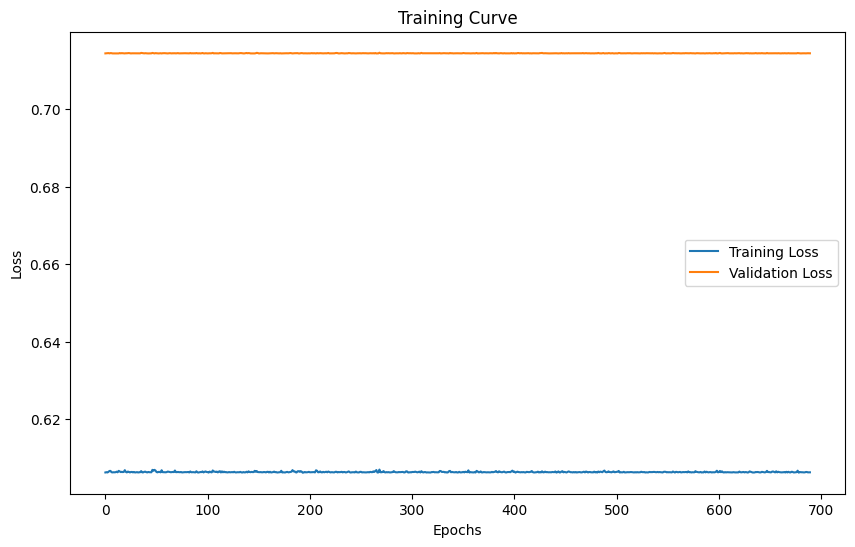

In [49]:
import matplotlib.pyplot as plt

# Lists to store loss values
training_losses = []
validation_losses = []

patience = 500
best_loss = np.inf
counter = 0

for epoch in range(10000):  # Assuming a maximum of 100 epochs
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Evaluate on validation set
    val_loss = evaluate(model, val_loader)
    validation_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/10000], Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
np.array(X_train).var(axis=0)

array([3.8689052e-12, 8.8817842e-14, 3.5527137e-11, ..., 5.1159077e-13,
       9.6722630e-13, 1.2789769e-13], dtype=float32)